In [1]:
import cv2
import time
import uuid # Import uuid library to generate unique image names
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [2]:
print("OpenCV version:", cv2.__version__)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)

OpenCV version: 4.10.0
TensorFlow version: 2.10.0
NumPy version: 1.26.0
Matplotlib version: 3.8.2


In [4]:
!nvidia-smi

Tue Dec 31 12:01:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              3W /   65W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18187373108645512558
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6660301294
locality {
  bus_id: 1
}
incarnation: 11167981923833258798
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 3731876046
locality {
  bus_id: 1
}
incarnation: 11481687073261232283
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [4]:
devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == "GPU":
        print(f"Device: {device.name}, Type: {device.device_type}, Description: {device.physical_device_desc}")


Device: /device:GPU:0, Type: GPU, Description: device: 0, name: DML, pci bus id: <undefined>
Device: /device:GPU:1, Type: GPU, Description: device: 1, name: DML, pci bus id: <undefined>


In [5]:
# manage GPU memory consumption in TensorFlow and is particularly useful to prevent Out of Memory (OOM) errors
gpus = tf.config.experimental.list_physical_devices('GPU')
print(len(gpus))
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

# By default, TensorFlow allocates the entire GPU memory available on a device at the start of execution, even if your program doesn't need it all. This can cause:

# OOM Errors: Other processes or applications using the GPU simultaneously may not get the memory they need, leading to failures.
# Wasted Resources: If your program doesn't use the entire allocated memory, it results in inefficiency.

2
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Data Collection, Processing & Labelling

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [15]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [18]:
# Download this file to the current directory
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [20]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Check face frame
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Face Frame', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [14]:
# To capture the anchor images
# Open the webcam
cap = cv2.VideoCapture(0)

# Set the interval for capturing images (0.5 seconds)
capture_interval = 0.3
last_capture_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]

    # Check if it's time to capture an image
    current_time = time.time()
    if current_time - last_capture_time >= capture_interval:
        # Create the unique file path for anchor images
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the anchor image
        cv2.imwrite(imgname, frame)
        
        # Update the last capture time
        last_capture_time = current_time

    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [7]:
# To capture the positive images
# Open the webcam
cap = cv2.VideoCapture(0)

# Set the interval for capturing images (0.5 seconds)
capture_interval = 0.3
last_capture_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]

    # Check if it's time to capture an image
    current_time = time.time()
    if current_time - last_capture_time >= capture_interval:
        # Create the unique file path for positive images
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the positive image
        cv2.imwrite(imgname, frame)
        
        # Update the last capture time
        last_capture_time = current_time

    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [12]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [53]:
# Creates a list of "file paths" to the images whose suffixes are .jpg
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg') 
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg')

# tf.data.Dataset is a TensorFlow class that provides an efficient, flexible, and scalable way to 
# handle data for machine learning pipelines. It is part of the TensorFlow tf.data API, designed to 
# simplify the process of preparing, managing, and feeding data into models for both training and inference.

In [54]:
print(anchor.as_numpy_iterator().next()) # therefore returns the image file path

b'data\\anchor\\507265c4-c74f-11ef-9891-48e7da5c7bf0.jpg'


In [55]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image, convert the jpeg image(byte string) to a tensor, why this ?
    # When reading images from files, they are in raw byte format. 
    # Deep learning models require numeric data to perform computations.
    # TensorFlow performs all operations (e.g., resizing, normalization) on tensors, not raw byte strings.
    img = tf.io.decode_jpeg(byte_img) 
    
    # Preprocessing steps - resizing the image to be 105x105x3 (refer the paper),
    # How does resizing the tensor work ? 
    # Think of the resizing process as mapping the pixel values from the original dimensions into the target dimensions. TensorFlow uses interpolation methods for this:
    # Bilinear (default): Smoothly interpolates between neighboring pixels. (search later in image processing)
    # Nearest Neighbor: Chooses the nearest pixel value without averaging.
    # Others: Bicubic, Lanczos, etc.
    img = tf.image.resize(img, (105,105))
    # Normalizing the data (0-255) to (0-1), (helps in improving the performance & convergence of neural networks)
    img = img / 255.0

    # Return image
    return img

In [56]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [57]:
# Now we don't have the labels for the datasets, we need to create them
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# Final output
# (
#   "path/to/anchor_image1.jpg",
#   "path/to/positive_image1.jpg",
#   1.0
# )

In [58]:
print(positives)
print(data)

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [59]:
samples = data.as_numpy_iterator()

In [60]:
example = samples.next()
samples.next()

(b'data\\anchor\\22c3ed13-c74f-11ef-8f45-48e7da5c7bf0.jpg',
 b'data\\positive\\16dc6b5f-c750-11ef-9dfd-48e7da5c7bf0.jpg',
 1.0)

In [61]:
def preprocess_dataset(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [62]:
res = preprocess_dataset(*example) # * is used to unpack the tuple

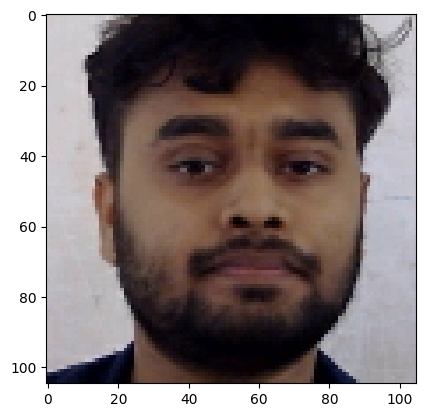

In [63]:
plt.imshow(res[1]) 

In [64]:
res[2]

1.0

In [65]:
# Build dataloader pipeline
data = data.map(preprocess_dataset)
data = data.cache()
data = data.shuffle(buffer_size=4) # Memory contraints thus buffer_size is set low

### Train/Test split

In [66]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

In [67]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) # so that we don't pick up the training sample
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(4)
test_data = test_data.prefetch(2)

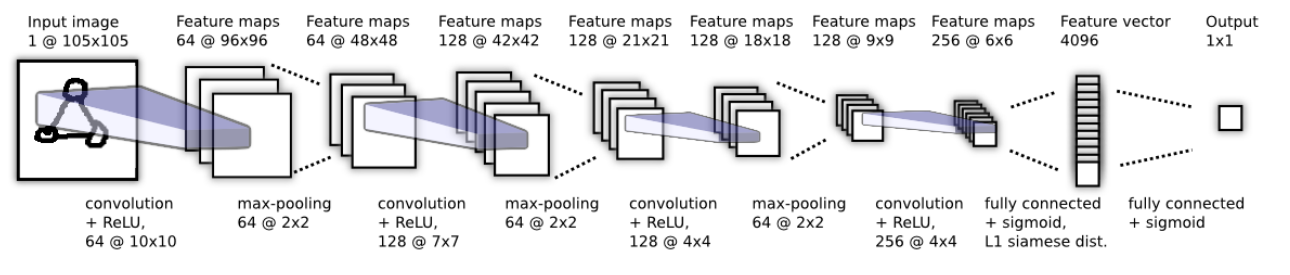

In [68]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [69]:
embedding = make_embedding()

In [70]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [71]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [72]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) # substraction of 4096 dimensional vectors
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [73]:
siamese_model = make_siamese_model()

In [74]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [75]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [76]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [77]:
os.makedirs('./training_checkpoints', exist_ok=True)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [78]:
test_batch = train_data.as_numpy_iterator()

In [79]:
batch_1 = test_batch.next()

In [80]:
X = batch_1[:2]

In [81]:
y = batch_1[2]

In [82]:
y

array([1., 1., 1., 1.], dtype=float32)

In [83]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [84]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [85]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [86]:
EPOCHS = 50

In [87]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
204/204 [==============================] - 54s 248ms/step
0.012208898 0.99828476 0.9931741

 Epoch 2/50
204/204 [==============================] - 51s 251ms/step
0.70075876 0.8696398 0.6860623

 Epoch 3/50
204/204 [==============================] - 51s 251ms/step
0.70607483 0.9965695 0.71463716

 Epoch 4/50
204/204 [==============================] - 51s 247ms/step
0.7107266 0.9965695 0.7137592

 Epoch 5/50
204/204 [==============================] - 52s 253ms/step
0.6852098 0.99828476 0.7149877

 Epoch 6/50
204/204 [==============================] - 53s 258ms/step
0.719908 0.9965695 0.7137592

 Epoch 7/50
204/204 [==============================] - 52s 255ms/step
0.724217 1.0 0.7144608

 Epoch 8/50
204/204 [==============================] - 54s 265ms/step
0.7284801 1.0 0.7153374

 Epoch 9/50
204/204 [=======================

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [89]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [90]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 167ms/step


In [91]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1]

In [92]:
y_true

array([0., 0., 0., 0.], dtype=float32)

In [93]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [94]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [95]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 571ms/step
0.0 0.0


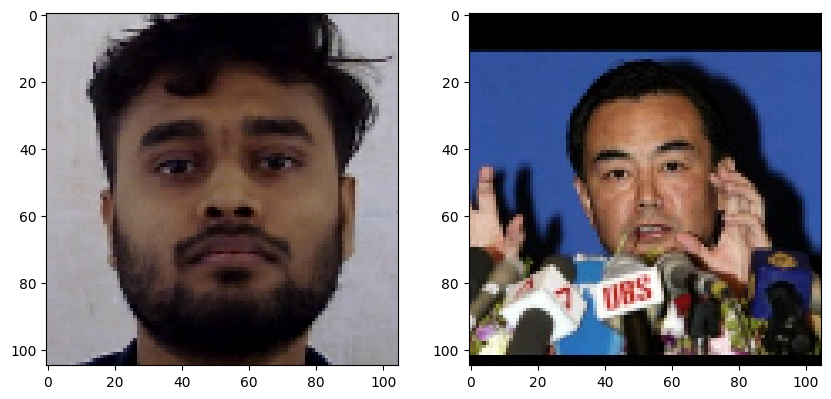

In [96]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [97]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [98]:
L1Dist

__main__.L1Dist

In [99]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [100]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 334ms/step


array([[0.5863105],
       [0.5863105]], dtype=float32)

In [102]:
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [103]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [104]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [105]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [108]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

C:\Users\reala\AppData\Local\Temp\ipykernel_9520\139549914.py:16: RuntimeWarning: invalid value encountered in scalar divide
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))


False
False
False
False
False
False


In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a